<a href="https://colab.research.google.com/github/jakey1610/MachineLearningL3/blob/master/coursework_pegasus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [4]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

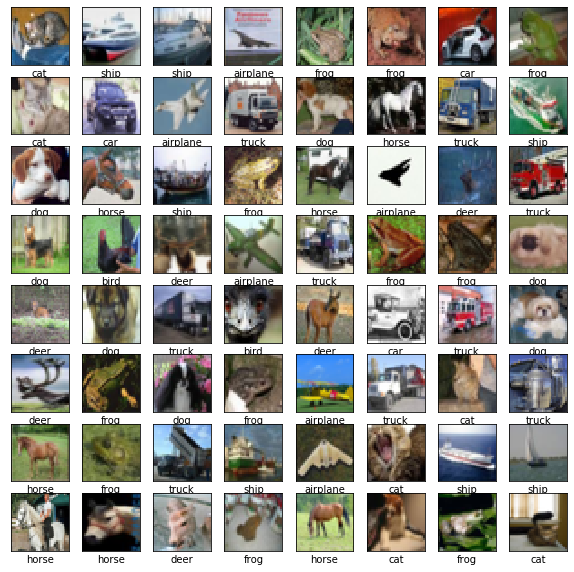

In [5]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define the Discriminatory Network model**

In [7]:
# define the discriminatory model
class DiscNet(nn.Module):
    def __init__(self):
        super(DiscNet, self).__init__()
        layers = nn.ModuleList()
        conv1 = nn.Sequential(nn.Conv2d(3,128,4,stride=2,padding=1,bias=False),nn.LeakyReLU(0.2,in_place=True))
        layers.append(conv1)
        conv2 = nn.Sequential(nn.Conv2d(128,256,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(256),nn.LeakyReLU(0.2))
        layers.append(conv2)
        conv3 = nn.Sequential(nn.Conv2d(265,512,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(512),nn.LeakyReLU(0.2))
        layers.append(conv3)
        conv4 = nn.Sequential(nn.Conv2d(512,1024,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(1024),nn.LeakyReLU(0.2))
        layers.append(conv4)
        dec = nn.Sequential(nn.Linear(1024*4*4,3),nn.Sigmoid())
        layers.append(dec)
        self.layers = layers

    def forward(self, x):
        x = self.encode(x)
        return x

    # encode (flatten as linear, then run first half of network)
    def encode(self, x):
        for i in range(4):
            x = self.layers[i](x)
        x = x.view(-1,1024*4*4)
        x = self.layers[4](x)
        return x

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

> Number of network parameters 11142659


**Define the Generative Network**

In [0]:
class GenNet(nn.Module):
  def __init__(self):
    super(GenNet,self).__init__()
    layers = nn.ModuleList()
    linear = nn.Linear(100,1024*4*4)
    layers.append(linear)
    conv1 = nn.Sequential(nn.ConvTranspose2d(1024,512,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(512),nn.ReLU(inplace=True))
    layers.append(conv1)
    conv2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(256),nn.ReLU(inplace=True))
    layers.append(conv2)
    conv3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(128),nn.ReLU(inplace=True))
    layers.append(conv3)
    conv4 = nn.Sequential(nn.ConvTranspose2d(128,1,4,stride=2,padding=1,bias=False))
    layers.append(conv4)
    dec = nn.Tanh()
    layers.append(dec)
    self.layers = layers
  def forward(self,x):
    x = self.layers[0](x)
    x = x.view(x.shape[0],1024,4,4)
    for i in range(4):
      x = self.layers[i+1](x)
    return self.layers[-1](x)


**Initialise the Optimisers**

In [0]:
DN = DiscNet().to(device)
GN = GenNet().to(device)
# initialise the optimisers
optimiser = torch.optim.Adam(DN.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimiser = torch.optim.Adam(GN.parameters(), lr=0.0001, betas=(0.5, 0.999))
epoch = 0
liveplot = PlotLosses()

**Discriminator Training Loop**

In [0]:
while (epoch<200):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(3000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        
        optimiser.zero_grad()
        p = DN(x)
        loss = nn.BCELoss()
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.item())

    # plot the loss
    liveplot.update({
        'loss': train_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generator Training Loop**

In [0]:
epoch=0
while (epoch<200):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(3000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        
        optimiser.zero_grad()
        p = DN(x)
        loss = nn.BCELoss()
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.item())

    # plot the loss
    liveplot.update({
        'loss': train_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generate a Pegasus, for example by interpolating between the latent space encodings of a horse and a bird**

In [0]:
example_1 = test_loader.dataset[13][0].to(device)  # horse
example_2 = test_loader.dataset[160][0].to(device) # bird

example_1_code = N.encode(example_1.unsqueeze(0))
example_2_code = N.encode(example_2.unsqueeze(0))

# this is some sad blurry excuse of a Pegasus, hopefully you can make a better one
bad_pegasus = N.encode(0.7*example_1_code + 0.3*example_2_code).squeeze(0)

plt.grid(False)
plt.imshow(bad_pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

#for i in range(len(test_loader.dataset.test_labels)):
#  print(class_names[test_loader.dataset.test_labels[i]] + '\t idx: ' + str(i))

**Sample a batch from the generative model to show the output diversity**

In [0]:
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
p = N(x)

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(p[i].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)